In [1]:
!pip install proglearn
!pip install git+https://github.com/neurodata/treeple.git

  Cloning https://github.com/neurodata/treeple.git to /tmp/pip-req-build-cv6y8t_i
  Running command git clone --filter=blob:none --quiet https://github.com/neurodata/treeple.git /tmp/pip-req-build-cv6y8t_i
  Resolved https://github.com/neurodata/treeple.git to commit 75c2cf919939574e4240fe261f053162039495cf
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for treeple: filename=treeple-0.10.3-cp311-cp311-linux_x86_64.whl size=2924556 sha256=6c55ecad7f937489288858a06682461e398f74a377238143e5cf45ef213c04f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-rt64ssk0/wheels/87/bd/56/9c9982c5af1eb667f0421e0000d3ed4b973b71c8e8903fa6cd
Successfully built treeple


In [27]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from treeple import ObliqueRandomForestClassifier
from proglearn.sims import generate_gaussian_parity
from sklearn.metrics import accuracy_score
from proglearn.sims import generate_spirals
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist, fashion_mnist

In [81]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi / 4)

X_train_xor, X_test_xor, y_train_xor, y_test_xor = train_test_split(X_xor, y_xor, test_size=0.2)
X_train_rxor, X_test_rxor, y_train_rxor, y_test_rxor = train_test_split(X_rxor, y_rxor, test_size=0.2)

task_train_xor = np.zeros(len(y_train_xor), dtype=int)
task_train_rxor = np.ones(len(y_train_rxor), dtype=int)
task_test_xor = np.zeros(len(y_test_xor), dtype=int)
task_test_rxor = np.ones(len(y_test_rxor), dtype=int)

X_train_multi = np.column_stack((np.vstack([X_train_xor, X_train_rxor]), np.hstack([task_train_xor, task_train_rxor])))
y_train_multi = np.hstack([y_train_xor, y_train_rxor])

X_test_multi_xor = np.column_stack((X_test_xor, np.zeros(len(y_test_xor), dtype=int)))
X_test_multi_rxor = np.column_stack((X_test_rxor, np.ones(len(y_test_rxor), dtype=int)))


In [82]:
num_trials = 100
xor_accuracies = []
rxor_accuracies = []

for _ in range(num_trials):
    start_time = time.time()
    sporf_mtl = ObliqueRandomForestClassifier(n_estimators=100)
    sporf_mtl.fit(X_train_multi, y_train_multi)
    training_time = time.time() - start_time
    y_pred_xor = sporf_mtl.predict(X_test_multi_xor)
    y_pred_rxor = sporf_mtl.predict(X_test_multi_rxor)

    xor_accuracies.append(accuracy_score(y_test_xor, y_pred_xor))
    rxor_accuracies.append(accuracy_score(y_test_rxor, y_pred_rxor))


In [83]:
xor_accuracies = np.array(xor_accuracies)
rxor_accuracies = np.array(rxor_accuracies)
single_task_xor_accuracies = []
single_task_rxor_accuracies = []

for _ in range(num_trials):
    start_time = time.time()
    sporf_xor = ObliqueRandomForestClassifier(n_estimators=100)
    sporf_xor.fit(X_train_xor, y_train_xor)
    y_pred_xor = sporf_xor.predict(X_test_xor)
    single_task_xor_accuracies.append(accuracy_score(y_test_xor, y_pred_xor))

    start_time = time.time()
    sporf_rxor = ObliqueRandomForestClassifier(n_estimators=100)
    sporf_rxor.fit(X_train_rxor, y_train_rxor)
    y_pred_rxor = sporf_rxor.predict(X_test_rxor)
    single_task_rxor_accuracies.append(accuracy_score(y_test_rxor, y_pred_rxor))

single_task_xor_accuracies = np.array(single_task_xor_accuracies)
single_task_rxor_accuracies = np.array(single_task_rxor_accuracies)


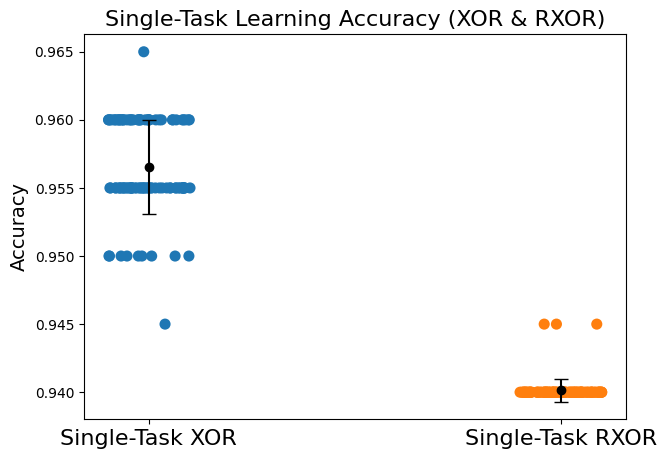

In [85]:
plt.figure(figsize=(7, 5))
sns.stripplot(data=[single_task_xor_accuracies, single_task_rxor_accuracies],
              jitter=True, size=8)

plt.errorbar([0, 1],
             [single_task_xor_accuracies.mean(), single_task_rxor_accuracies.mean()],
             yerr=[single_task_xor_accuracies.std(), single_task_rxor_accuracies.std()],
             fmt="o", color="black", capsize=5, zorder=3)

plt.xticks([0, 1], ["Single-Task XOR", "Single-Task RXOR"], fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Single-Task Learning Accuracy (XOR & RXOR)", fontsize=16)
plt.show()

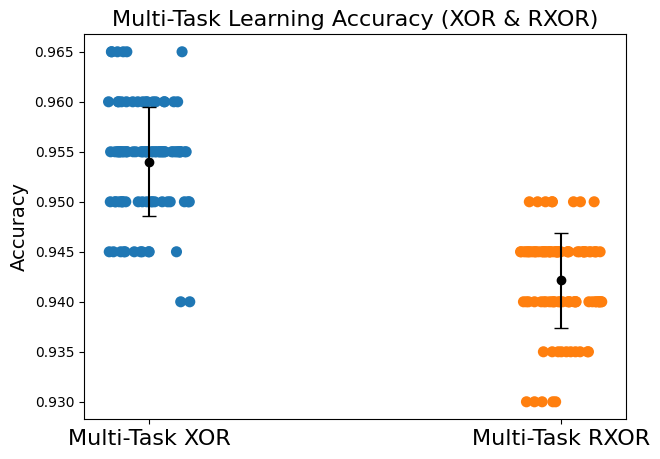

In [87]:
plt.figure(figsize=(7, 5))
sns.stripplot(data=[xor_accuracies, rxor_accuracies],
              jitter=True, size=8)

plt.errorbar([0, 1],
             [xor_accuracies.mean(), rxor_accuracies.mean()],
             yerr=[xor_accuracies.std(), rxor_accuracies.std()],
             fmt="o", color="black", capsize=5, zorder=3)

plt.xticks([0, 1], ["Multi-Task XOR", "Multi-Task RXOR"], fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Multi-Task Learning Accuracy (XOR & RXOR)", fontsize=16)
plt.show()

In [88]:
single_task_xor_mean = np.mean(single_task_xor_accuracies)
single_task_xor_std = np.std(single_task_xor_accuracies)
single_task_rxor_mean = np.mean(single_task_rxor_accuracies)
single_task_rxor_std = np.std(single_task_rxor_accuracies)
multi_task_xor_mean = np.mean(xor_accuracies)
multi_task_xor_std = np.std(xor_accuracies)
multi_task_rxor_mean = np.mean(rxor_accuracies)
multi_task_rxor_std = np.std(rxor_accuracies)

single_task_xor_time = training_time
single_task_rxor_time = training_time
multi_task_time = training_time

print(f"Single-Task XOR Accuracy: {single_task_xor_mean:.4f} ± {single_task_xor_std:.4f}")
print(f"Single-Task RXOR Accuracy: {single_task_rxor_mean:.4f} ± {single_task_rxor_std:.4f}")

print(f"Multi-Task XOR Accuracy: {multi_task_xor_mean:.4f} ± {multi_task_xor_std:.4f}")
print(f"Multi-Task RXOR Accuracy: {multi_task_rxor_mean:.4f} ± {multi_task_rxor_std:.4f}")

print(f"Single-Task XOR Training Time: {single_task_xor_time:.2f} sec")
print(f"Single-Task RXOR Training Time: {single_task_rxor_time:.2f} sec")

print(f"Total Multi-Task Training Time: {multi_task_time:.2f} sec")

Single-Task XOR Accuracy: 0.9565 ± 0.0034
Single-Task RXOR Accuracy: 0.9401 ± 0.0009
Multi-Task XOR Accuracy: 0.9540 ± 0.0054
Multi-Task RXOR Accuracy: 0.9421 ± 0.0048
Single-Task XOR Training Time: 0.21 sec
Single-Task RXOR Training Time: 0.21 sec
Total Multi-Task Training Time: 0.21 sec


#Spiral 3 vs Sprial 5


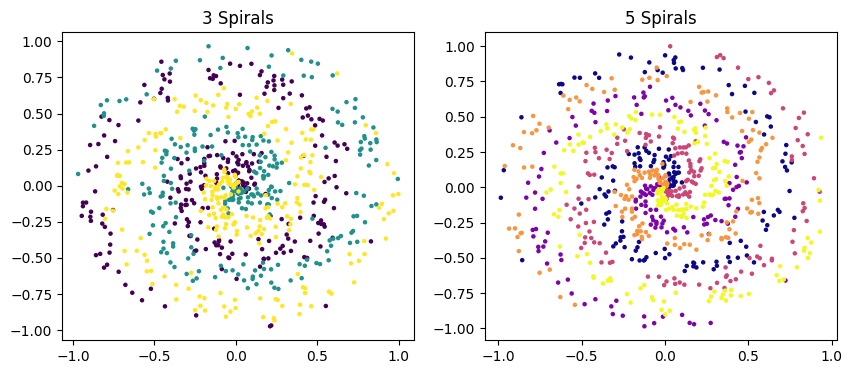

In [36]:
n_samples = 750
spiral3, y_spiral3 = generate_spirals(n_samples, 3, noise=0.8)
spiral5, y_spiral5 = generate_spirals(n_samples, 5, noise=0.4)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(spiral3[:, 0], spiral3[:, 1], c=y_spiral3, cmap="viridis", s=5)
plt.title("3 Spirals")

plt.subplot(1, 2, 2)
plt.scatter(spiral5[:, 0], spiral5[:, 1], c=y_spiral5, cmap="plasma", s=5)
plt.title("5 Spirals")

plt.show()

In [77]:
num_trials = 100

results = {
    "Spiral 3": {"accuracy": [], "time": []},
    "Spiral 5": {"accuracy": [], "time": []},
    "Multi-Task": {"accuracy": [], "time": []}
}

multi_task_spiral3_accuracies = []
multi_task_spiral5_accuracies = []

for _ in range(num_trials):
    spiral3, y_spiral3 = generate_spirals(750, 3, noise=0.8)
    spiral5, y_spiral5 = generate_spirals(750, 5, noise=0.4)

    X_train_spiral3, X_test_spiral3, y_train_spiral3, y_test_spiral3 = train_test_split(spiral3, y_spiral3, test_size=0.2)
    X_train_spiral5, X_test_spiral5, y_train_spiral5, y_test_spiral5 = train_test_split(spiral5, y_spiral5, test_size=0.2)

    scaler = StandardScaler()
    X_train_all = np.vstack([X_train_spiral3, X_train_spiral5])
    scaler.fit(X_train_all)

    X_train_spiral3 = scaler.transform(X_train_spiral3)
    X_train_spiral5 = scaler.transform(X_train_spiral5)
    X_test_spiral3 = scaler.transform(X_test_spiral3)
    X_test_spiral5 = scaler.transform(X_test_spiral5)

    start = time.time()
    sporf = ObliqueRandomForestClassifier(n_estimators=100)
    sporf.fit(X_train_spiral3, y_train_spiral3)
    y_pred = sporf.predict(X_test_spiral3)
    results["Spiral 3"]["accuracy"].append(accuracy_score(y_test_spiral3, y_pred))
    results["Spiral 3"]["time"].append(time.time() - start)

    start = time.time()
    sporf.fit(X_train_spiral5, y_train_spiral5)
    y_pred = sporf.predict(X_test_spiral5)
    results["Spiral 5"]["accuracy"].append(accuracy_score(y_test_spiral5, y_pred))
    results["Spiral 5"]["time"].append(time.time() - start)

    X_train_multi = np.vstack([X_train_spiral3, X_train_spiral5])
    y_train_multi = np.concatenate([y_train_spiral3, y_train_spiral5])
    task_labels_train = np.concatenate([np.zeros(len(y_train_spiral3)), np.ones(len(y_train_spiral5))])
    X_train_multi = np.column_stack((X_train_multi, task_labels_train))

    X_test_multi = np.vstack([X_test_spiral3, X_test_spiral5])
    y_test_multi = np.concatenate([y_test_spiral3, y_test_spiral5])
    task_labels_test = np.concatenate([np.zeros(len(y_test_spiral3)), np.ones(len(y_test_spiral5))])
    X_test_multi = np.column_stack((X_test_multi, task_labels_test))

    start = time.time()
    sporf.fit(X_train_multi, y_train_multi)
    y_pred_multi = sporf.predict(X_test_multi)
    results["Multi-Task"]["accuracy"].append(accuracy_score(y_test_multi, y_pred_multi))
    results["Multi-Task"]["time"].append(time.time() - start)

    X_test_spiral3_with_task = np.column_stack((X_test_spiral3, np.zeros(len(y_test_spiral3))))
    X_test_spiral5_with_task = np.column_stack((X_test_spiral5, np.ones(len(y_test_spiral5))))

    y_pred_spiral3 = sporf.predict(X_test_spiral3_with_task)
    y_pred_spiral5 = sporf.predict(X_test_spiral5_with_task)

    multi_task_spiral3_accuracies.append(accuracy_score(y_test_spiral3, y_pred_spiral3))
    multi_task_spiral5_accuracies.append(accuracy_score(y_test_spiral5, y_pred_spiral5))


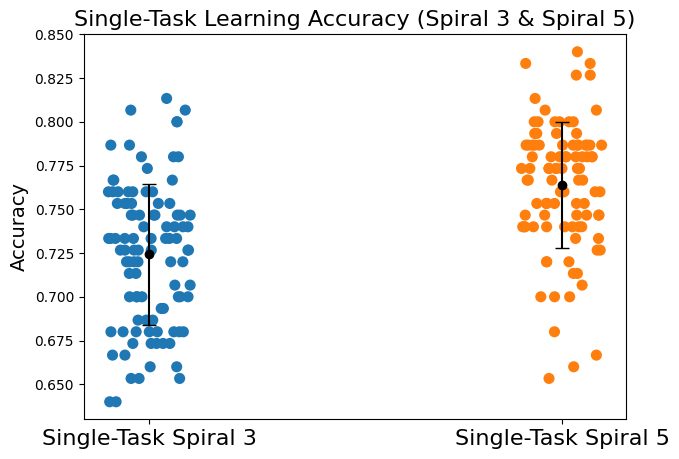

In [78]:
for key in results:
    results[key]["accuracy"] = np.array(results[key]["accuracy"])
    results[key]["time"] = np.array(results[key]["time"])

plt.figure(figsize=(7, 5))
sns.stripplot(data=[results["Spiral 3"]["accuracy"], results["Spiral 5"]["accuracy"]],
              jitter=True, size=8)

plt.errorbar([0, 1], [results["Spiral 3"]["accuracy"].mean(), results["Spiral 5"]["accuracy"].mean()],
                 yerr=[results["Spiral 3"]["accuracy"].std(), results["Spiral 5"]["accuracy"].std()],
                 fmt="o", color="black", capsize=5, zorder=3)

plt.xticks([0, 1], ["Single-Task Spiral 3", "Single-Task Spiral 5"], fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Single-Task Learning Accuracy (Spiral 3 & Spiral 5)", fontsize=16)
plt.show()

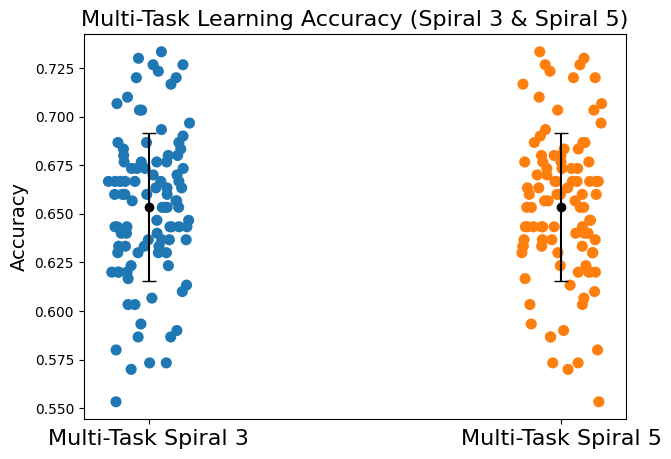

In [79]:
plt.figure(figsize=(7, 5))
sns.stripplot(data=[results["Multi-Task"]["accuracy"], results["Multi-Task"]["accuracy"]],
              jitter=True, size=8)

plt.errorbar([0, 1], [results["Multi-Task"]["accuracy"].mean(), results["Multi-Task"]["accuracy"].mean()],
             yerr=[results["Multi-Task"]["accuracy"].std(), results["Multi-Task"]["accuracy"].std()],
             fmt="o", color="black", capsize=5, zorder=3)

plt.xticks([0, 1], ["Multi-Task Spiral 3", "Multi-Task Spiral 5"], fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Multi-Task Learning Accuracy (Spiral 3 & Spiral 5)", fontsize=16)
plt.show()


In [80]:
spiral3_mean = np.mean(results["Spiral 3"]["accuracy"])
spiral3_std = np.std(results["Spiral 3"]["accuracy"])
spiral5_mean = np.mean(results["Spiral 5"]["accuracy"])
spiral5_std = np.std(results["Spiral 5"]["accuracy"])

multi_task_spiral3_mean = np.mean(multi_task_spiral3_accuracies)
multi_task_spiral3_std = np.std(multi_task_spiral3_accuracies)
multi_task_spiral5_mean = np.mean(multi_task_spiral5_accuracies)
multi_task_spiral5_std = np.std(multi_task_spiral5_accuracies)

spiral3_time_mean = np.mean(results["Spiral 3"]["time"])
spiral3_time_std = np.std(results["Spiral 3"]["time"])
spiral5_time_mean = np.mean(results["Spiral 5"]["time"])
spiral5_time_std = np.std(results["Spiral 5"]["time"])
multi_task_time_mean = np.mean(results["Multi-Task"]["time"])
multi_task_time_std = np.std(results["Multi-Task"]["time"])


print(f"Spiral 3 Accuracy: {spiral3_mean:.4f} ± {spiral3_std:.4f}")
print(f"Spiral 3 Training Time: {spiral3_time_mean:.2f} sec ± {spiral3_time_std:.2f} sec")

print(f"Spiral 5 Accuracy: {spiral5_mean:.4f} ± {spiral5_std:.4f}")
print(f"Spiral 5 Training Time: {spiral5_time_mean:.2f} sec ± {spiral5_time_std:.2f} sec")

print(f"Multi-Task Spiral 3 Accuracy: {multi_task_spiral3_mean:.4f} ± {multi_task_spiral3_std:.4f}")
print(f"Multi-Task Spiral 5 Accuracy: {multi_task_spiral5_mean:.4f} ± {multi_task_spiral5_std:.4f}")

print(f"Total Multi-Task Training Time: {multi_task_time_mean:.2f} sec ± {multi_task_time_std:.2f} sec")


Spiral 3 Accuracy: 0.7242 ± 0.0403
Spiral 3 Training Time: 0.28 sec ± 0.07 sec
Spiral 5 Accuracy: 0.7637 ± 0.0360
Spiral 5 Training Time: 0.29 sec ± 0.07 sec
Multi-Task Spiral 3 Accuracy: 0.6557 ± 0.0517
Multi-Task Spiral 5 Accuracy: 0.6513 ± 0.0562
Total Multi-Task Training Time: 0.27 sec ± 0.07 sec
